# VGG11 Implementation

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## VGG BackBone

In [134]:
class VGG11BackBone(nn.Module):
  def __init__(self):
    super(VGG11BackBone, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1 = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2 = nn.BatchNorm2d(256)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1 = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2 = nn.BatchNorm2d(512)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1 = nn.BatchNorm2d(512)
    self.pool5_1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2 = nn.BatchNorm2d(512)

    # nn.ModuleList 또는 nn.Sequential로 묶는 게 더 간편할 듯

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)

    return x

## VGG11 for Classification

In [135]:
class VGG11Classification(nn.Module):
  def __init__(self, num_classes=7):
    super(VGG11Classification, self).__init__()

    self.backbone = VGG11BackBone()
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # channel별 feature를 channe당 하나의 값을 갖는 vector로 만들어주기 위한 용도
    self.gap = nn.AdaptiveAvgPool2d(1)
    # shape of fc_out's weight: (num_classes, 512)
    self.fc_out = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.pool5(x)
    x = self.gap(x)
    x = torch.flatten(x, 1)
    x = self.fc_out(x)

    return x

## VGG11 for Segmentation

In [146]:
class VGG11Segmentation(nn.Module):
  def __init__(self, num_classes=7):
    super(VGG11Segmentation, self).__init__()

    self.backbone = VGG11BackBone()

    # 각각의 pixel마다 num_classes 채널의 각 클래스에 속할 예측값을 갖도록 하는 1D convolution
    with torch.no_grad():
      self.conv_out = nn.Conv2d(512, num_classes, kernel_size=1, padding=0, stride=1)

    self.upsample = torch.nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)

  def forward(self, x):
    print("shape of x:", (x.shape))
    x = self.backbone(x)
    x = self.conv_out(x)
    x = self.upsample(x)

    assert x.shape == (1, 7, 224, 224)

    return x

  def copy_last_layer(self, fc_out):
    reshaped_fc_out = fc_out.weight.detach()
    reshaped_fc_out = torch.reshape(reshaped_fc_out, (7, 512, 1, 1))
    self.conv_out.weight = torch.nn.Parameter(reshaped_fc_out)

    assert self.conv_out.weight[0][0] == fc_out.weight[0][0]

    return

In [147]:
test_input = torch.randn((1, 3, 224, 224))

model_classification = VGG11Classification()
out = model_classification(test_input)
print(f'shape of output: {out.shape}')

model_segmentation = VGG11Segmentation()
out = model_segmentation(test_input)
print(f'shape of output: {out.shape}')

shape of output: torch.Size([1, 7])
shape of x: torch.Size([1, 3, 224, 224])
shape of output: torch.Size([1, 7, 224, 224])


# Dataset

## Label

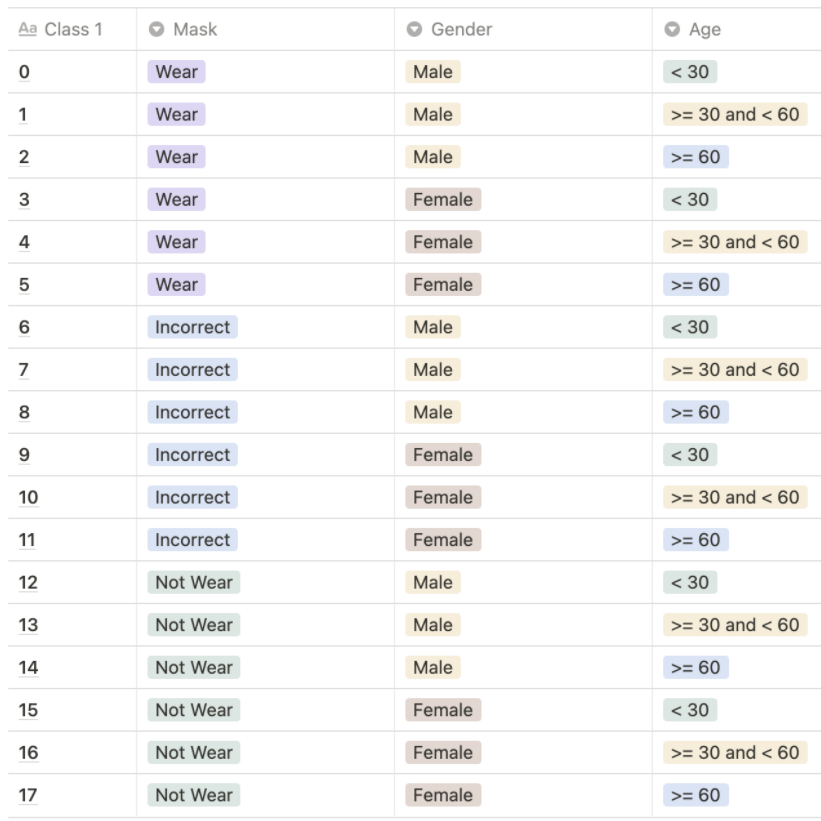

In [148]:
import os
import cv2
import numpy as np

from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [149]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [150]:
class MaskDataset(Dataset):
  def __init__(self, data_root, input_size=224, transform=None):
    super(MaskDataset, self).__init__()

    self.img_list = glob(os.path.join(data_root, '*.jpg'))
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.

    if self.transform:
      img = self.transform(img)

    label = self._get_class_idx_from_img_name(img_path)

    return img, label

  def __len__(self):
    return self.len

  def _get_class_idx_from_img_name(self, img_path):
    img_name = os.path.basename(img_path)

    if 'normal' in img_name:
      return 0
    elif 'mask1' in img_name:
      return 1
    elif 'mask2' in img_name:
      return 2
    elif 'mask3' in img_name:
      return 3
    elif 'mask4' in img_name:
      return 4
    elif 'mask5' in img_name:
      return 5
    elif 'incorrect_mask' in img_name:
      return 6
    else:
      raise ValueError("%s is not a valid filename. Please change the name of %s." % (img_name, img_path))


# Load Model

In [151]:
model_root = './model.pth'

model_classification = VGG11Classification()
model_classification.load_state_dict(torch.load(model_root, map_location=device))

<All keys matched successfully>

In [152]:
model_segmentation = VGG11Segmentation()

model_segmentation.backbone = model_classification.backbone

fc_out = model_classification.fc_out
model_segmentation.copy_last_layer(fc_out)

# Test

In [153]:
data_root = '.'
input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
batch_size = 1

test_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

shape of x: torch.Size([1, 3, 224, 224])


<ipython-input-160-9e40437c9c3a>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [seg_r, seg_c] = np.where(seg == np.int(label[0].cpu()))


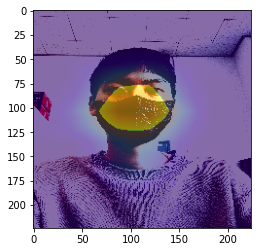

In [160]:
import matplotlib.pyplot as plt

model_segmentation.to(device).float()
model_segmentation.eval()

for iter, (img, label) in enumerate(test_loader):
  img = img.float().to(device)

  out = model_segmentation(img)

  predict = out[0]

  heat = predict[label[0]]
  result_h = heat.detach().cpu().numpy()

  heat_r, heat_c = np.where(result_h > np.percentile(result_h, 95))

  # pixel마다 channel을 기준으로 가장 높은 값을 지니는 값의 channel index
  seg = torch.argmax(predict, dim=0)
  seg = seg.detach().cpu().numpy()

  [seg_r, seg_c] = np.where(seg == np.int(label[0].cpu()))

  result_s = np.zeros((224, 224))

  for idx, r in enumerate(heat_r):
    c = heat_c[idx]
    if (r in seg_r) and (c in seg_c):
      result_s[r,c] = 1

  want_to_check_heat_map_result = True

  # shape of img: (channel, width, height)
  # to show image using pyplot, (width, height, channel)
  plt.imshow(img[0].cpu().permute(1, 2, 0))

  if want_to_check_heat_map_result:
    plt.imshow(result_h, cmap='jet', alpha=0.3)

  plt.imshow(result_s, alpha=0.4)
  plt.show()